# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1uAUJGEUzfNj6OsWNAimnYCw7eKaHhMUfU1MTj9YwYw4/edit?usp=sharing), [grading rubric](https://docs.google.com/document/d/1UYkYtDtHJS2nzodDjJ3X3c2AdYNuj3ueki58p_hQGhA/edit)_


**Background:**

Imagine your apartment lease is ending at the close of the year, and the search for a new apartment is on. To narrow down potential neighborhoods, you've identified key criteria that matter to you.

**Goals:**

- quiet neighborhood (relating to dataset of `311 complaints`)
- a lot of greenery (relating to dataset of `2015 tree census`) 
- within budget (relating to dataset of `Zillow`)

## Setup

In [5]:
# All import statements needed for the project
import pathlib
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import requests
import re
import psycopg2
import shapely

from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, TIMESTAMP, Date, text
from geoalchemy2 import Geometry, WKTElement
from datetime import datetime, timedelta
from shapely.geometry import Point
from shapely.wkb import dumps
from pathlib import Path
from geopy.distance import geodesic
from ipywidgets import IntSlider, interact, fixed

In [6]:
# Any constants you might need; some have been added for you

## File Path
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

## Application token and json url for downloading nyc_311 and nyc_tree
NYC_DATA_APP_TOKEN = "NJflFVV2YiwlXmMlt4Y9jwTGO"
API_311 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
API_TREE='https://data.cityofnewyork.us/resource/uvpi-gqnh.json'

## Soql for NYC_311 and NYC_TREE Download
SOQL_BASE_QUERY_311 = f"{API_311}?$where=created_date between '2015-01-01T00:00:00' and '2023-10-31T00:00:00'&$limit=1000000"
SOQL_QUERIES_311 = {f"query_{i}": f"{SOQL_BASE_QUERY_311}&$offset={(i-1)*1000000}" for i in range(1, 26)}
SOQL_QUERY_TREE=f"{API_TREE}?$where=created_at between '2015-01-01T00:00:00' and '2015-12-31T23:59:59'&$limit=1000000000"

## Postgresql Database information
DB_NAME = "GroupProject"
DB_USER = 'postgres'
DB_PASSWORD = ''
DB_HOST = 'localhost'
DB_URL=f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}'

## Database schema file
DB_SCHEMA_FILE = "schema.sql"

## campus geometry information
latitude = 40.80737875669467
longitude = -73.96253174434912
point = Point(longitude, latitude)
point_wkt = f"POINT({longitude} {latitude})"
point_wkb = dumps(point, hex=True)

## directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [7]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

In Part 1, we processed four datasets: **NYC311**, **NYCTree**, **NYC Zipcode**, and **NYC Zillow**.

### 1. Download and Clean NYC_311
- **Download:**
  - Implemented a function `download_nyc_json_data` using application tokens and API URLs to retrieve JSON data, converting it to a DataFrame.
  - Executed `download_311_data` to handle the large dataset. It utilized SOQL queries to download 1 million records at a time, repeating this 25 times. Each batch was saved as a CSV file to manage the dataset's size efficiently.

- **Clean:**
  - Implemented function `load_and_clean_311_data` 
      - read and concatenate all saved CSV files into a single DataFrame.
      - Selected columns (`unique_key`, `created_date`, `complaint_type`, `incident_zip`, `latitude`, `longitude`) and created a new 'location' column using GeoPandas for spatial data representation.
      - Dropped the original `latitude` and `longitude` columns and renamed `incident_zip` to `zipcode`.
      - Removed rows with missing zip codes and converted the data types of columns (`unique_key`, `created_date`, `complaint_type`, `zipcode`) for consistency and accuracy.
      - Transformed the DataFrame into a GeoDataFrame with 'location' as the geometry column for spatial analysis.


In [7]:
# this function is used to download json url using application token
def download_nyc_json_data(query: str) -> pd.DataFrame:
    headers = {'X-App-Token': NYC_DATA_APP_TOKEN }
    response = requests.get(query, headers=headers)
    df = pd.read_json(response.text)
    return df

In [8]:
# this function is used download nyc_311 data
def download_311_data(queries_dict: dict):
    for query_name, query in queries_dict.items():
        query_df = download_nyc_json_data(query)
        query_df.to_csv(f"{query_name}_data.csv", index=False)

In [9]:
# this function is used to load and clean 311 data
def load_and_clean_311_data() -> GeoDataFrame:
    ## read and concat all 311 data, which previously saved as csv file
    all_data = pd.concat([pd.read_csv(f"{query_name}_data.csv", low_memory=False) for query_name in SOQL_QUERIES_311], ignore_index=True)
    
    ## choose columns which will be used for later analysis
    data_311 = all_data[['unique_key', 'created_date', 'complaint_type', 'incident_zip', 'latitude', 'longitude']].copy()

    # Create a new column 'location' without modifying the original DataFrame
    data_311['location'] = gpd.points_from_xy(data_311['longitude'], data_311['latitude'], crs="EPSG:4326")

    # Drop latitude and longitude columns
    data_311 = data_311.drop(['latitude', 'longitude'], axis=1)

    # Rename columns
    data_311 = data_311.rename(columns={"incident_zip": "zipcode"})

    # Drop rows with missing zip codes
    data_311['zipcode'] = pd.to_numeric(data_311['zipcode'], errors='coerce')
    data_311 = data_311.dropna(subset=['zipcode'])

    # Change data types
    convert_dict = {'unique_key': int, 'created_date': 'datetime64[ns]', 'complaint_type': str, 'zipcode': int}
    data_311 = data_311.astype(convert_dict)

    # Create GeoDataFrame with 'location' as the geometry column
    geo_data_311 = gpd.GeoDataFrame(data_311, geometry='location')

    return geo_data_311

### 2. Download and Clean NYC_tree
- **Download:**
  - Utilized the `download_nyc_json_data` function with application tokens, API URLs, and a SOQL query specifically designed to retrieve tree data for the year 2015.

- **Clean:**
  - Selected relevant columns: `tree_id`, `status`, `health`, `spc_common` (species), `zipcode`, `latitude`, and `longitude`.
  - Transformed latitude and longitude data into a GeoDataFrame with a 'location' column using GeoPandas, representing each tree's spatial data.
  - Dropped the original `latitude` and `longitude` columns for data efficiency.
  - Renamed the column `spc_common` to `species` for clarity and consistency.


In [10]:
# this function is used to load and clean tree data
def download_and_clean_tree_data() -> GeoDataFrame:
    # Download tree data for the year 2015
    tree_data = download_nyc_json_data(SOQL_QUERY_TREE)

    # Select relevant columns
    selected_columns = ['tree_id', 'status', 'health', 'spc_common', 'zipcode', 'latitude', 'longitude']
    tree_data = tree_data[selected_columns]

    # Convert latitude and longitude to a GeoDataFrame with a 'location' column
    tree_data['location'] = gpd.points_from_xy(tree_data['longitude'], tree_data['latitude'], crs="EPSG:4326")

    # Drop latitude and longitude columns
    tree_data = tree_data.drop(['latitude', 'longitude'], axis=1)

    # Rename columns
    tree_data = tree_data.rename(columns={"spc_common": "species"})

    return gpd.GeoDataFrame(tree_data, geometry='location')

### 3. Load and Clean NYC_Zipcode

- **Load:**
  - Imported zipcode data using GeoPandas’ `read_file` function, with error handling to catch and report any issues during the import process.

- **Clean:**
  - Selected only the necessary columns: `ZIPCODE` and `geometry`, and renamed them to `zipcode` and `location` for clarity.
  - Converted the data into a GeoDataFrame, setting `location` as the geometry column.
  - Updated the coordinate reference system to `EPSG:4326` for consistent spatial data representation.
  - Changed the data type of `zipcode` to integer for accurate data handling.
  - Eliminated duplicate entries in the `zipcode` column to ensure data uniqueness and integrity.


In [11]:
# this function is used to load and clean zipcode data
def load_and_clean_zipcodes_data(zipcode_datafile: Path) -> GeoDataFrame or None: 
    try:
        data = gpd.read_file(zipcode_datafile)
        
        # Select relevant columns and rename them
        data_nyc = data[['ZIPCODE', 'geometry']].rename(
            columns={"ZIPCODE": "zipcode", "geometry": "location"})
        
        # Create GeoDataFrame with the selected and renamed columns
        zipcode_nyc = gpd.GeoDataFrame(data_nyc, geometry='location')
        
        # Change data types and coordinate reference system
        zipcode_nyc = zipcode_nyc.to_crs(epsg=4326)
        zipcode_nyc = zipcode_nyc.astype({'zipcode': int})
        
        # Drop duplicate zipcodes, keeping the first occurrence
        zipcode_nyc = zipcode_nyc.drop_duplicates(subset=['zipcode'])
        
        return zipcode_nyc
    
    except Exception as e:
        print(f"Error: {e}. Could not read file: {zipcode_datafile}")
        return None

### 4. Load and Clean NYC_Zillow

- **Load:**
  - Utilized Pandas to read the Zillow dataset from a specified CSV file (`zillow_datafile`).

- **Clean:**
  - Filtered the dataset to include only entries for New York City.
  - Isolated relevant columns, focusing on `RegionName` and all numeric columns representing dates.
  - Transformed the dataset using the `melt` function in Pandas, converting date columns into rows for a more streamlined structure. The columns for this transformation were `RegionName` as `id_vars` and the numeric columns as values.
  - Dropped rows with missing values in the newly created `rent` column to maintain data integrity.
  - Renamed the `RegionName` column to `zipcode` for clarity and alignment with other datasets.
  - Converted the `recorded_date` column to a datetime format to facilitate time-based analysis.


In [12]:
# this function is used to load and clean zillow data
def load_and_clean_zillow_data(zillow_datafile: Path)->pd.DataFrame:
    data = pd.read_csv(zillow_datafile)
    
    # Only get the data of "NY" state
    zillow_data_NY = data[data.City == "New York"]
    
    # Get DataFrame containing selected columns and all numeric columns
    numeric_columns = data.filter(regex='^\d').columns.tolist()
    zillow_NY_dataset = zillow_data_NY[["RegionName"] + numeric_columns]
    
    # Melt the DataFrame to transform the date columns into rows
    zillow_NY_dataset_melted = pd.melt(zillow_NY_dataset, id_vars=["RegionName"], var_name="recorded_date", value_name="rent")
    
    # Drop rows with missing values in the "value" column
    zillow_NY_dataset_melted = zillow_NY_dataset_melted.dropna(subset=["rent"])
    
    # Rename some columns
    zillow_NY_dataset_melted = zillow_NY_dataset_melted.rename(columns={"RegionName": "zipcode"})
    
    # Convert "date" column to date format
    zillow_NY_dataset_melted["recorded_date"] = pd.to_datetime(zillow_NY_dataset_melted["recorded_date"])
    
    return zillow_NY_dataset_melted

### 5. Load all data
- **Load Data:**
  - Utilize the previously set functions to load each dataset.

- **Verify Data:**
  - For each loaded dataset, perform the following checks:
    1. **Display Info:**
       - Use the `.info()` method to get an overview of each dataset. This includes details like column names, data types, and the number of non-null values, which are crucial for assessing data completeness and structure.
    2. **Display Initial Rows:**
       - Employ the `.head()` method to view the first few rows of each dataset. This step is important for a preliminary check to ensure that the data is loaded correctly and matches the expected format.


In [13]:
## this function is used to load all dataset
def load_all_data()-> GeoDataFrame or pd.DataFrame:
    data_311 = load_and_clean_311_data()
    data_tree = download_and_clean_tree_data()
    data_zipcode = load_and_clean_zipcodes_data(ZIPCODE_DATA_FILE)
    data_zillow = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    
    return (
        data_311,
        data_tree,
        data_zipcode,
        data_zillow
    )

In [14]:
data_311, data_tree, data_zipcode, data_zillow = load_all_data()

In [15]:
# Show basic info about 311 dataframe
data_311.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23807000 entries, 0 to 24627961
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   unique_key      int64         
 1   created_date    datetime64[ns]
 2   complaint_type  object        
 3   zipcode         int64         
 4   location        geometry      
dtypes: datetime64[ns](1), geometry(1), int64(2), object(1)
memory usage: 1.1+ GB


In [16]:
# Show first 5 entries about 311 dataframe
data_311.head()

,unique_key,created_date,complaint_type,zipcode,location
0,59288833,2023-10-31,Food Poisoning,11103,POINT (-73.91848 40.75963)
1,59285818,2023-10-31,Food Poisoning,10016,POINT (-73.97879 40.74432)
2,59287303,2023-10-31,Food Poisoning,10280,POINT (-74.01598 40.71110)
3,59287302,2023-10-31,Food Poisoning,11372,POINT (-73.89328 40.74881)
4,59285819,2023-10-31,Food Poisoning,10021,POINT (-73.95441 40.76886)


In [17]:
# Show basic info about tree dataframe
data_tree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 509525 entries, 0 to 509524
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   tree_id   509525 non-null  int64   
 1   status    509525 non-null  object  
 2   health    485498 non-null  object  
 3   species   485498 non-null  object  
 4   zipcode   509525 non-null  int64   
 5   location  509525 non-null  geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 23.3+ MB


In [18]:
# Show first 5 entries about tree dataframe
data_tree.head()

,tree_id,status,health,species,zipcode,location
0,180683,Alive,Fair,red maple,11375,POINT (-73.84422 40.72309)
1,200540,Alive,Fair,pin oak,11357,POINT (-73.81868 40.79411)
2,204026,Alive,Good,honeylocust,11211,POINT (-73.93661 40.71758)
3,204337,Alive,Good,honeylocust,11211,POINT (-73.93446 40.71354)
4,189565,Alive,Good,American linden,11215,POINT (-73.97598 40.66678)


In [19]:
# Show basic info about zipcode dataframe
data_zipcode.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   248 non-null    int64   
 1   location  248 non-null    geometry
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB


In [20]:
# Show first 5 entries about zipcode dataframe
data_zipcode.head()

,zipcode,location
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [21]:
# Show basic info about zillow dataframe
data_zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9039 entries, 5 to 15224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zipcode        9039 non-null   int64         
 1   recorded_date  9039 non-null   datetime64[ns]
 2   rent           9039 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 282.5 KB


In [22]:
# Show first 5 entries about zillow dataframe
data_zillow.head()

,zipcode,recorded_date,rent
5,11226,2015-01-31,1944.609891
7,10025,2015-01-31,3068.951823
13,11206,2015-01-31,2482.829299
14,11221,2015-01-31,2125.738807
20,11235,2015-01-31,1687.789898


## Part 2: Storing Data
In this part, the focus is on creating a PostgreSQL database and storing the processed data efficiently.

- **Create PostgreSQL Database:**
  - Establish a new PostgreSQL database named **"GroupProject"**.
  - Within this database, create a **PostGIS extension**. PostGIS is an essential extension for handling geographical and location data, making it ideal for the datasets we have.

- **Create Tables and Indexes:**
  - In the "GroupProject" database, create four distinct tables corresponding to the datasets: data_311, data_tree, data_zipcode, and data_zillow.
  - For 3 table, create **indexes** for geometry column.

- **Write Data from DataFrames to Tables:**
  - Transfer the data from the GeoPandas/Pandas DataFrames into the corresponding tables in the database.


### 1. Create PostgreSQL Database and Set Postgis Extension

In [28]:
# first step: create database 'GroupProject'in PostgreSQL
!createdb GroupProject

createdb: error: database creation failed: ERROR:  database "GroupProject" already exists


In [29]:
# second step: create postgis extension
!psql --dbname GroupProject -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


### 2. Create Tables and Indexes

- Use **SQLAlchemy** to Create Tables
    - **Function Definition for Table Creation**:
      - Defined a function `create_tables` with the _engine_ as its parameter.
      - Set primary keys and data types for each of the four tables: `nyc_311`, `nyc_tree`, `nyc_zipcode`, `nyc_zillow`.
      - Bound table definitions to the engine using `MetaData` from SQLAlchemy. Invoked the `create_all` method to execute table creation in the database.

    - **Establishing Database Connection**:
      - Connected to the PostgreSQL database using the `create_engine` function from SQLAlchemy.
      - Called the `create_tables` function to create tables in the database.

- Use **psycopg2** to Create Indexes
    - **Function Definition for Index Creation**:
      - Defined a function `create_indexes` with the _connection_ as its parameter.
      - Ran SQL commands to create GIST indexes on the `location` columns of `nyc_311`, `nyc_tree`, and `nyc_zipcode`.

    - **Establishing Database Connection**:
      - Connected to the database using the `psycopg2.connect` function.
      - Called the `create_indexes` function to create indexes in the database.


In [30]:
# this function is used to create tables
def create_tables(engine)-> None:
    metadata = MetaData()

    nyc_311 = Table(
        'nyc_311', metadata,
        Column('unique_key', Integer, primary_key=True),
        Column('created_date', TIMESTAMP),
        Column('complaint_type', String),
        Column('zipcode', Integer),
        Column('location', Geometry('POINT', srid=4326))
    )

    nyc_tree = Table(
        'nyc_tree', metadata,
        Column('tree_id', Integer, primary_key=True),
        Column('status', String),
        Column('health', String),
        Column('species', String),
        Column('zipcode', Integer),
        Column('location', Geometry('POINT', srid=4326))
    )

    nyc_zipcode = Table(
        'nyc_zipcode', metadata,
        Column('zipcode', Integer, primary_key=True),
        Column('location', Geometry('POLYGON', srid=4326))
    )
    
    nyc_zillow = Table(
        'nyc_zillow', metadata,
        Column('zipcode', Integer, primary_key=True),
        Column('recorded_date', Date),
        Column('rent', Float)
    )

    metadata.create_all(engine)

In [31]:
# this function is used to create indexes
def create_indexes(connection)-> None:
    sql_create_indexes = """
    CREATE INDEX IF NOT EXISTS idx_nyc_311_location ON "nyc_311" USING gist (location);
    CREATE INDEX IF NOT EXISTS idx_nyc_tree_location ON "nyc_tree" USING gist (location);
    CREATE INDEX IF NOT EXISTS idx_nyc_zipcode_location ON "nyc_zipcode" USING gist (location);
    """

    with connection.cursor() as cursor:
        cursor.execute(sql_create_indexes)

In [32]:
# use sqlalchemy to create tables in the postgresql
engine = create_engine(DB_URL)
create_tables(engine)

In [33]:
# use psycopg2 to create indexes in the postgresql
with psycopg2.connect(DB_URL) as connection:
    create_indexes(connection)

### Add Data to Database
- **Define a Function to Write DataFrames to Tables**:
  - Created a function `write_dataframes_to_table` with parameters _df_name_ (the DataFrame to be written) and _table_name_ (the target table in the database).
  - Implemented a conditional check: if the DataFrame is a GeoPandas DataFrame, it utilizes the `to_postgis` method for writing spatial data. For regular Pandas DataFrames, the `to_sql` method is used.

- **Execute Function for Data Insertion**:
  - Called the `write_dataframes_to_table` function to transfer data from the four dataframes (`NYC311`, `NYCTree`, `NYC Zipcode`, `NYC Zillow`) into their respective tables in the database.


In [34]:
# this function is used to write date into tables
def write_dataframes_to_table(df_name:pd.DataFrame, table_name:str)->None:
    engine = create_engine(DB_URL)
    
    # if it is geopandas dataframe, use "gpd.to_postgis", else use "pd.to_sql"
    try:
        df_name.to_postgis(table_name, engine, if_exists='replace', index=False)
    except:
        df_name.to_sql(table_name, engine, if_exists='replace', index=False)

In [ ]:
write_dataframes_to_table(data_311, 'nyc_311')
write_dataframes_to_table(data_tree, 'nyc_tree')
write_dataframes_to_table(data_zipcode,"nyc_zipcode")
write_dataframes_to_table(data_zillow,"nyc_zillow")

## Part 3: Understanding the Data

In [8]:
# Define a function to write the queries to file
# Setting the filename for the SQL query file
def write_query_to_file(query:str, file_name:Path)-> None:
    with open(file_name, 'w') as file:
        file.write(query)  # Writing the SQL query to the specified file

### Query 1 : Which area might be more calm to live in?
**Question:**
Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code. The query result should have two columns, one row per zip code, with the number of complaints in descending order.

**Solution:**
- **Objective:** Analyze and count noise-related 311 complaints in New York City by zip code from October 1st, 2022, to September 30th, 2023.
- **Method:** The code filters complaints from the nyc_311 database, groups them by zip code, and calculates the total number of noise complaints for each zip code.
- **Sorting:** Results are sorted in descending order, showing zip codes with the most noise complaints first.
- **Output:** Produces a table listing each zip code with its corresponding number of noise complaints, helping to identify areas with high noise issues.

In [12]:
# SQL query to find the number of 311 complaints per zip code
QUERY_1 = """
SELECT 
      zipcode, 
      COUNT(*) AS complaint_count
FROM 
      nyc_311
WHERE 
      created_date BETWEEN '2022-10-01' AND '2023-09-30'
      AND complaint_type LIKE '%Noise%'
GROUP BY 
      zipcode
ORDER BY 
      complaint_count DESC;
"""

In [13]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    print(f"Zip Code ｜ Complaint Count")
    for row in result:
        print(f"{row.zipcode}｜{row.complaint_count}")

Zip Code ｜ Complaint Count
10023｜15595
10031｜12439
10456｜12291
10025｜11903
10453｜11408
10457｜11086
10458｜10642
10032｜10619
10452｜10544
10468｜10309
11226｜10184
10466｜10067
11201｜10051
11221｜10017
11414｜9725
10002｜8889
11238｜8580
11207｜8504
10467｜8237
10033｜8201
10027｜8089
10034｜7676
11216｜7518
10011｜7290
11237｜7277
10009｜7234
11206｜6838
11368｜6710
10029｜6627
11208｜6505
10040｜6490
11225｜6374
10026｜6363
11211｜6193
11385｜6190
10472｜6178
11212｜6110
10463｜5922
10003｜5848
10460｜5705
10030｜5494
10019｜5461
10462｜5300
11233｜5239
11372｜4976
10016｜4970
11220｜4916
11366｜4886
11249｜4884
11419｜4860
11377｜4784
11213｜4757
11373｜4750
11433｜4723
10028｜4679
10024｜4556
11101｜4545
10451｜4464
10035｜4430
10455｜4402
11203｜4398
11217｜4346
10459｜4338
11231｜4297
11420｜4280
11103｜4217
11222｜4142
11375｜4011
11209｜3905
11235｜3618
10454｜3528
11215｜3525
10473｜3460
10036｜3445
11357｜3344
10014｜3340
10128｜3306
11435｜3286
11229｜3284
11223｜3269
11234｜3267
11218｜3222
10001｜3207
11230｜3201
10012｜3184
10461｜3164
11106｜3145
11

In [14]:
# Setting the filename for the SQL query file
QUERY_1_FILENAME = QUERY_DIR / "top_zipcodes_by_complaints.sql"
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2: Where has the most greenery?
**Question:** Using just the trees table, which 10 zip codes have the most trees? The query result should have two columns, 10 rows. The rows should be sorted by the total number of trees, descending.

**Solution:** 
- **Objective:** Identify the top 10 zip codes in New York City with the highest number of living trees.
- **Method:** The code queries the nyc_tree database, focusing on 'Alive' trees, groups them by zip code, and counts the trees in each zip code.
- **Sorting and Limiting:** Results are sorted in descending order of tree count, and the query is limited to the top 10 zip codes with the most trees.
- **Output:** Produces a table displaying the 10 zip codes with the highest number of trees, offering insights into the areas with the most greenery.

In [9]:
# SQL query to find the number of trees per zip code
QUERY_2 = """
SELECT 
     zipcode, 
     COUNT(*) AS tree_count
FROM 
     nyc_tree
WHERE 
     status = 'Alive'
GROUP BY 
     zipcode
ORDER BY 
     tree_count DESC
LIMIT 10;
"""

In [10]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    print(f"Zip Code| Tree Count")
    for row in result:
        print(f"{row.zipcode}| {row.tree_count}")

Zip Code| Tree Count
10312| 20155
10314| 15291
10306| 11905
10309| 11133
11208| 7762
11207| 7456
11385| 7382
11230| 6936
10308| 6479
10305| 6239


In [11]:
# Setting the filename for the SQL query file
QUERY_2_FILENAME = QUERY_DIR / "zipcodes_by_tree_count.sql"
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3: Can I afford a place in the areas with the most trees?
**Question:** Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code? The query should have a JOIN statement. The query result should have two columns (not three) and 10 rows. The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

**Solution:**
- **Objective:** Determine the average rent for August 2023 in the top 10 tree-rich zip codes in New York City.
- **Method:** The code first identifies the 10 zip codes with the most living trees, then joins this data with the nyc_zillow database to calculate the average rent in these areas for August 2023.
- **Formatting:** The average rent is formatted to be human-readable, displaying numbers in a standard currency format (e.g., 2,879.58).
- **Output:** Generates a table listing each of the top 10 tree-rich zip codes with their corresponding average rent, sorted by the number of trees in descending order.


In [15]:
# SQL query to find the zip code with most trees
QUERY_3 = """
SELECT 
    tc.zipcode, 
    TO_CHAR(AVG(z.rent), 'FM9,999,999.00') as average_rent
FROM 
    (
        SELECT 
            zipcode, 
            COUNT(*) AS tree_count
        FROM 
            nyc_tree
        WHERE 
            status = 'Alive'
        GROUP BY 
            zipcode
        ORDER BY 
            COUNT(*) DESC
        LIMIT 10
    ) AS tc
JOIN 
    nyc_zillow z ON tc.zipcode = z.zipcode
WHERE 
    z.recorded_date BETWEEN '2023-08-01' AND '2023-08-31'
GROUP BY 
    tc.zipcode, tc.tree_count
ORDER BY 
    tc.tree_count DESC
"""

In [16]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    print(f"Zip Code| Average Rent")
    for row in result:
        print(f"{row.zipcode}|{row.average_rent}")

Zip Code| Average Rent
10312|1,775.09
10314|2,465.47
10306|2,331.54
10309|1,832.01
11208|2,737.55
11207|3,079.09
11385|3,064.48
11230|2,657.04
10305|2,176.37


In [17]:
# Setting the filename for the SQL query file
QUERY_3_FILENAME = QUERY_DIR / "average_rent_top_tree_zipcodes.sql"
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?

**Question:** For the month of January 2023, return the 5 zip codes with the lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count and complaint count for each zip code by using JOIN statements. The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows: five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

**Solution:**
- **Objective:** Explore potential correlations between average rent, tree count, and 311 complaint count in NYC zip codes for January 2023, focusing on the five zip codes with the highest and lowest average rents.
- **Method:** The code performs a complex analysis involving multiple JOIN statements. It first calculates the average rent for each zip code, then ranks them to identify the top and bottom five. It also aggregates tree and complaint counts for these zip codes.
- **Formatting:** Average rent values are formatted for readability (e.g., 2,879.58 instead of 2879.575128).
- **Output:** Generates a table with 10 rows, listing the zip codes with the five highest and five lowest average rents, along with their corresponding tree and complaint counts, to investigate potential correlations.

In [18]:
# SQL query to find the correlation between rent, trees and complaints
QUERY_4 = """
WITH RentData AS (
    SELECT 
        zipcode, 
        AVG(rent) AS average_rent
    FROM 
        nyc_zillow
    WHERE 
        recorded_date BETWEEN '2023-01-01' AND '2023-01-31'
    GROUP BY 
        zipcode
), RentRank AS (
    SELECT 
        zipcode, 
        average_rent,
        RANK() OVER (ORDER BY average_rent DESC) AS high_rank,
        RANK() OVER (ORDER BY average_rent ASC) AS low_rank
    FROM 
        RentData
), TreeData AS (
    SELECT 
        zipcode, 
        COUNT(*) AS tree_count
    FROM 
        nyc_tree
    WHERE 
        status = 'Alive'
    GROUP BY 
        zipcode
), ComplaintData AS (
    SELECT 
        zipcode, 
        COUNT(*) AS complaint_count
    FROM 
        nyc_311
    WHERE 
        created_date BETWEEN '2023-01-01' AND '2023-01-31'
    GROUP BY 
        zipcode
)
SELECT 
    r.zipcode, 
    TO_CHAR(r.average_rent, 'FM9,999,999.00') as formatted_rent, 
    t.tree_count, 
    c.complaint_count
FROM 
    RentRank r
JOIN 
    TreeData t ON r.zipcode = t.zipcode
JOIN 
    ComplaintData c ON r.zipcode = c.zipcode
WHERE 
    r.high_rank <= 5 OR r.low_rank <= 5
ORDER BY 
    r.high_rank, r.low_rank
"""

In [19]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    print("Zipcode |  Average Rent |  Tree Count |  Complaint Count")
    for row in result:
        print(f"{row.zipcode} |  {row.formatted_rent} |  {row.tree_count} |  {row.complaint_count}")


Zipcode |  Average Rent |  Tree Count |  Complaint Count
10007 |  7,270.24 |  338 |  250
10282 |  7,143.35 |  230 |  39
10013 |  5,480.11 |  1132 |  740
10069 |  4,959.67 |  112 |  35
10011 |  4,741.87 |  2040 |  1487
10458 |  1,883.08 |  3012 |  3587
11357 |  1,829.66 |  2339 |  900
10453 |  1,820.23 |  2752 |  2941
10462 |  1,801.89 |  3973 |  2276
10309 |  1,380.51 |  11133 |  800


In [20]:
# Setting the filename for the SQL query file
QUERY_4_FILENAME = QUERY_DIR / "rent_tree_complaint_correlation.sql"
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5: Where has the most greenery (take 2)?
**Question:** Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table. The query should have a JOIN statement. The query results should match exactly the results of Query 2.

**Solution:**
- **Objective:** Refine the analysis of the amount of greenery (living trees) in each zip code, using both the nyc_tree and nyc_zipcode tables, with spatial data to accurately match trees to zip codes.
- **Method:** The code joins the tree data with zip code boundaries, counting trees only if they are physically located within the zip code's boundaries.
- **Spatial Analysis:** Utilizes ST_Contains to ensure that only trees within the geographic boundary of each zip code are counted.
- **Output:** Produces a list, limited to 2 zip codes, showing the number of living trees in each zip code, ordered by the tree count in descending order.

In [21]:
# SQL query to find the number of trees per zip code
QUERY_5 = """
SELECT 
     z.zipcode, 
     COUNT(*) as tree_count
FROM 
     nyc_tree t
JOIN 
     nyc_zipcode z ON ST_Contains(z.location, t.location)
WHERE 
     t.status = 'Alive'
GROUP BY 
     z.zipcode
ORDER BY 
     tree_count DESC
LIMIT 2;
"""

In [22]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    print("Zipcode | Tree Count")
    for row in result:
        print(f"{row.zipcode} | {row.tree_count}")

Zipcode | Tree Count
10312 | 20155
10314 | 15291


In [23]:
# Setting the filename for the SQL query file
QUERY_5_FILENAME = QUERY_DIR / "greenery_with_zipcode_spatial_join.sql"
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6: What is the immediate area like?
**Question:** Using the following coordinate pair on campus, which trees are within ½ mile radius of this point? (Latitude: 40.80737875669467, Longitude: -73.96253174434912)The result should have 5 columns (ID, species, health, status, and coordinate location of each tree). You may use regular Python to help construct the geometric object needed for setting the radius in the query.

**Solution:**
- **Objective:** Identify trees within a ½ mile radius of a specific coordinate point on a campus.
- **Method:** The code utilizes a spatial query (ST_DWithin) in the nyc_tree database to find trees within 804.672 meters of the given coordinates.
- **Data Columns:** The output includes the tree ID, species, health status, current status, and the exact geographic location of each tree.
- **Output:** Generates a table listing trees within the specified radius, providing detailed information about each tree, which helps in understanding the immediate greenery around the given point.

In [24]:
# SQL query to find the coordinate pair of trees
QUERY_6 = f"""
SELECT 
     tree_id, 
     species, 
     health, 
     status, 
     ST_AsText(location) AS location
FROM 
     nyc_tree
WHERE 
     ST_DWithin(location, '{point_wkt}'::geography, 804.672)
"""

In [25]:
# Print the result for the query 
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    print("ID | Species | Health | Status | Location")
    for row in result:
        print(f"{row.tree_id} | {row.species} | {row.health} | {row.status} | {row.location}")

ID | Species | Health | Status | Location
198514 | pin oak | Good | Alive | POINT(-73.9620798 40.80230109)
209919 | London planetree | Good | Alive | POINT(-73.96331506 40.80881155)
209921 | London planetree | Good | Alive | POINT(-73.96340334 40.80874458)
203887 | willow oak | Good | Alive | POINT(-73.96071917 40.80572583)
196440 | American elm | Fair | Alive | POINT(-73.96412322 40.81114538)
209913 | pin oak | Good | Alive | POINT(-73.96312072 40.80907709)
196605 | American elm | Good | Alive | POINT(-73.96715782 40.80738644)
196614 | None | None | Stump | POINT(-73.96769955 40.80650311)
188558 | London planetree | Good | Alive | POINT(-73.96052882 40.80361816)
204127 | Japanese zelkova | Fair | Alive | POINT(-73.96208728 40.80521641)
188841 | honeylocust | Good | Alive | POINT(-73.95822529 40.8088019)
190326 | Japanese zelkova | Good | Alive | POINT(-73.95627225 40.80385376)
189406 | ginkgo | Fair | Alive | POINT(-73.95892624 40.80767399)
198510 | pin oak | Good | Alive | POINT(-73.

In [26]:
# Setting the filename for the SQL query file
QUERY_6_FILENAME = QUERY_DIR / "trees_near_coordinate.sql"
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1: What can I expect to put up with in NYC?
**Question:** First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). Then, create an appropriate visualization for the number of complaints per day over $timeframe for those complaint types.  

**Solution:** 
- **Objective:** Visualize the daily count of the top 3 complaint types in NYC from October 1st, 2022, to September 30th, 2023.

- **Data Retrieval:** Query: Fetches daily counts of complaints for the three most common types within the specified timeframe.

- **Data Visualization:**
    - Plot Type: Generates a line plot for each complaint type over the given period.
    - Visualization Details: The plot shows dates on the x-axis, complaint counts on the y-axis, and includes a legend for each complaint type.
- **Result:** The resulting plot provides a clear view of the frequency and trends of the top 3 complaint types in NYC over a year, offering insights into common urban issues residents might encounter.

In [27]:
#Fetches daily counts of complaints for the three most common types 
def get_data_for_complaints()->pd.DataFrame:
    complaints_per_day_query = """
    SELECT 
        created_date::date, 
        complaint_type, 
        COUNT(*) as complaint_count
    FROM 
        nyc_311
    WHERE 
        created_date BETWEEN '2022-10-01' AND '2023-09-30'
        AND complaint_type IN (
            SELECT complaint_type
            FROM nyc_311
            WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
            GROUP BY complaint_type
            ORDER BY COUNT(*) DESC
            LIMIT 3
        )
    GROUP BY created_date::date, complaint_type
    ORDER BY created_date
    """

    with engine.connect() as conn:
        complaints_data = pd.read_sql(complaints_per_day_query, conn)

    return complaints_data

In [28]:
#Generates a line plot for each complaint type over the given period
def plot_complaints(dataframe:pd.DataFrame)->None:
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plotting the data for each complaint type
    for complaint_type in dataframe['complaint_type'].unique():
        filtered_data = dataframe[dataframe['complaint_type'] == complaint_type]
        axes.plot(filtered_data['created_date'], filtered_data['complaint_count'], label=complaint_type)

    # Labeling and styling
    axes.set_title("Top 3 NYC Complaint Types per Day")
    axes.set_xlabel("Date")
    axes.set_ylabel("Number of Complaints")
    axes.legend()

    plt.show()

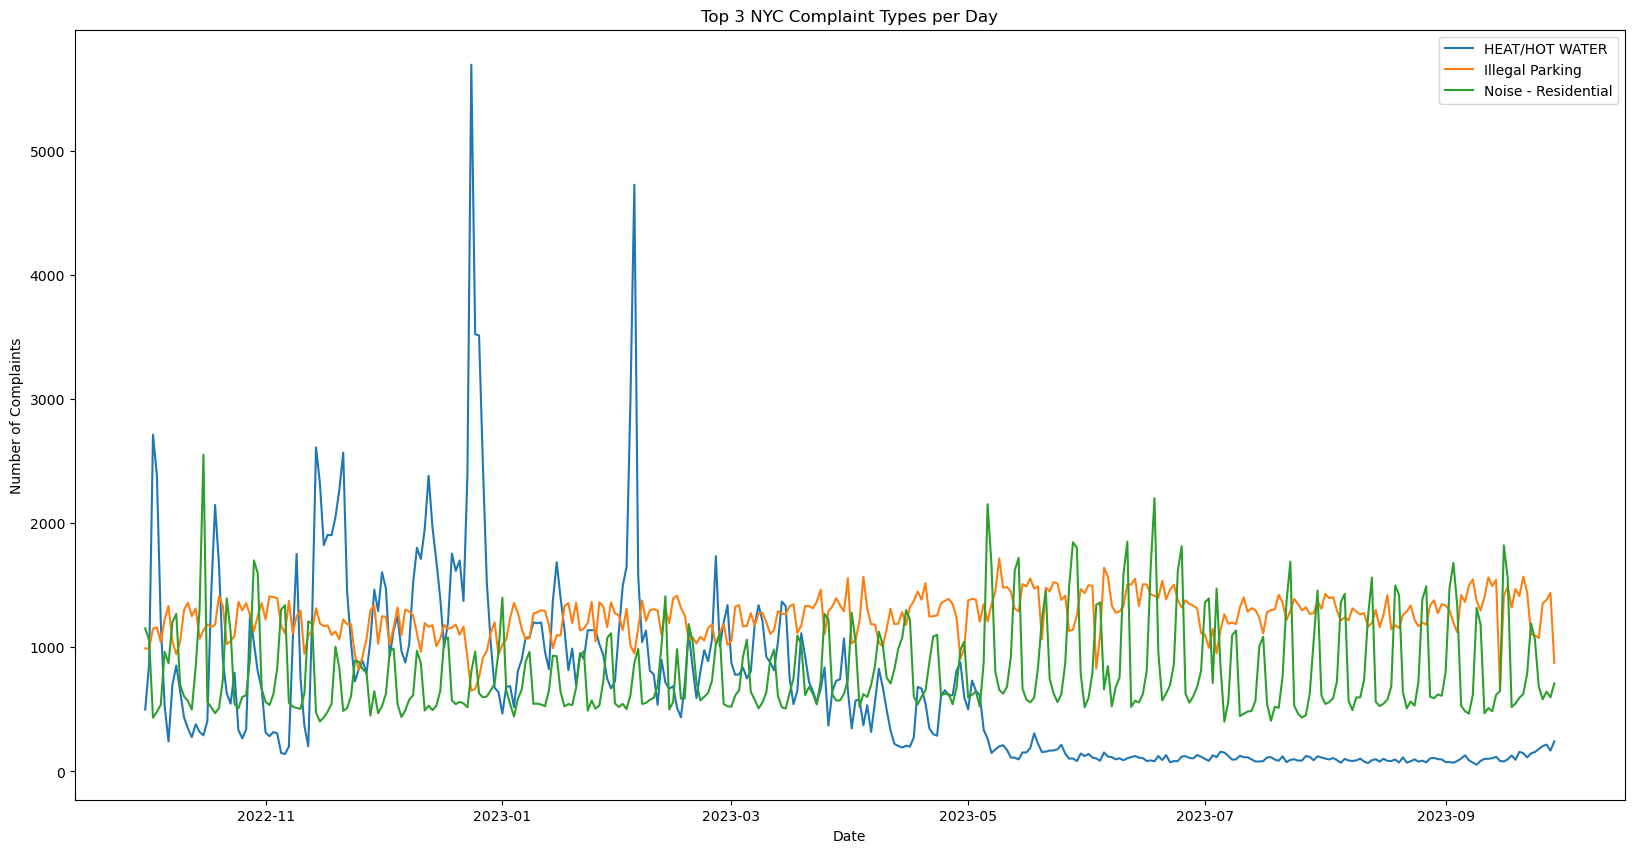

In [29]:
# Show the result
complaints_data = get_data_for_complaints()
plot_complaints(complaints_data)

### Visualization 2: What are the most common complaints in the immediate area?
**Question:** Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive).

**Solution:**
- **Objective:** Display the top 10 most common complaints in the zip code 10027 area from October 1st, 2018, to September 30th, 2023.

- **Data Retrieval:**
    - Query: Extracts data for the top 10 complaint types based on frequency within the specified period for zip code 10027.
    - Database Interaction: Conducts a SQL query to gather data from the nyc_311 database.
- **Data Visualization:**
    - Chart Type: Creates a bar chart to represent the count of each of the top 10 complaints.
    - Visualization Details: The bar chart displays complaint types on the x-axis and their corresponding counts on the y-axis, with labels rotated for better readability.
- **Result:** The visualization provides an easy-to-understand representation of the most prevalent complaints in zip code 10027 over a five-year period, highlighting the key issues faced by residents in this area.

In [30]:
#Extracts data for the top 10 complaint types based on frequency within the specified period for zip code 10027
def get_data_for_most_common_complaints()->pd.DataFrame:
    complaints_query = """
    SELECT 
        complaint_type, 
        COUNT(*) as complaint_count
    FROM 
        nyc_311
    WHERE 
        zipcode = 10027 AND
        created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY 
        complaint_type
    ORDER BY 
        complaint_count DESC
    LIMIT 10
    """

    with engine.connect() as conn:
        complaints_data = pd.read_sql(complaints_query, conn)

    return complaints_data

In [31]:
#Creates a bar chart to represent the count of each of the top 10 complaints
def plot_most_common_complaints(dataframe:pd.DataFrame):
    figure, axes = plt.subplots(figsize=(20, 10))
    # Plotting a bar chart
    axes.bar(dataframe['complaint_type'], dataframe['complaint_count'], color='skyblue')

    # Labeling and styling
    axes.set_title("Top 10 Complaints in Zip Code 10027 (Oct 2018 - Sep 2023)")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Number of Complaints")
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

    plt.show()

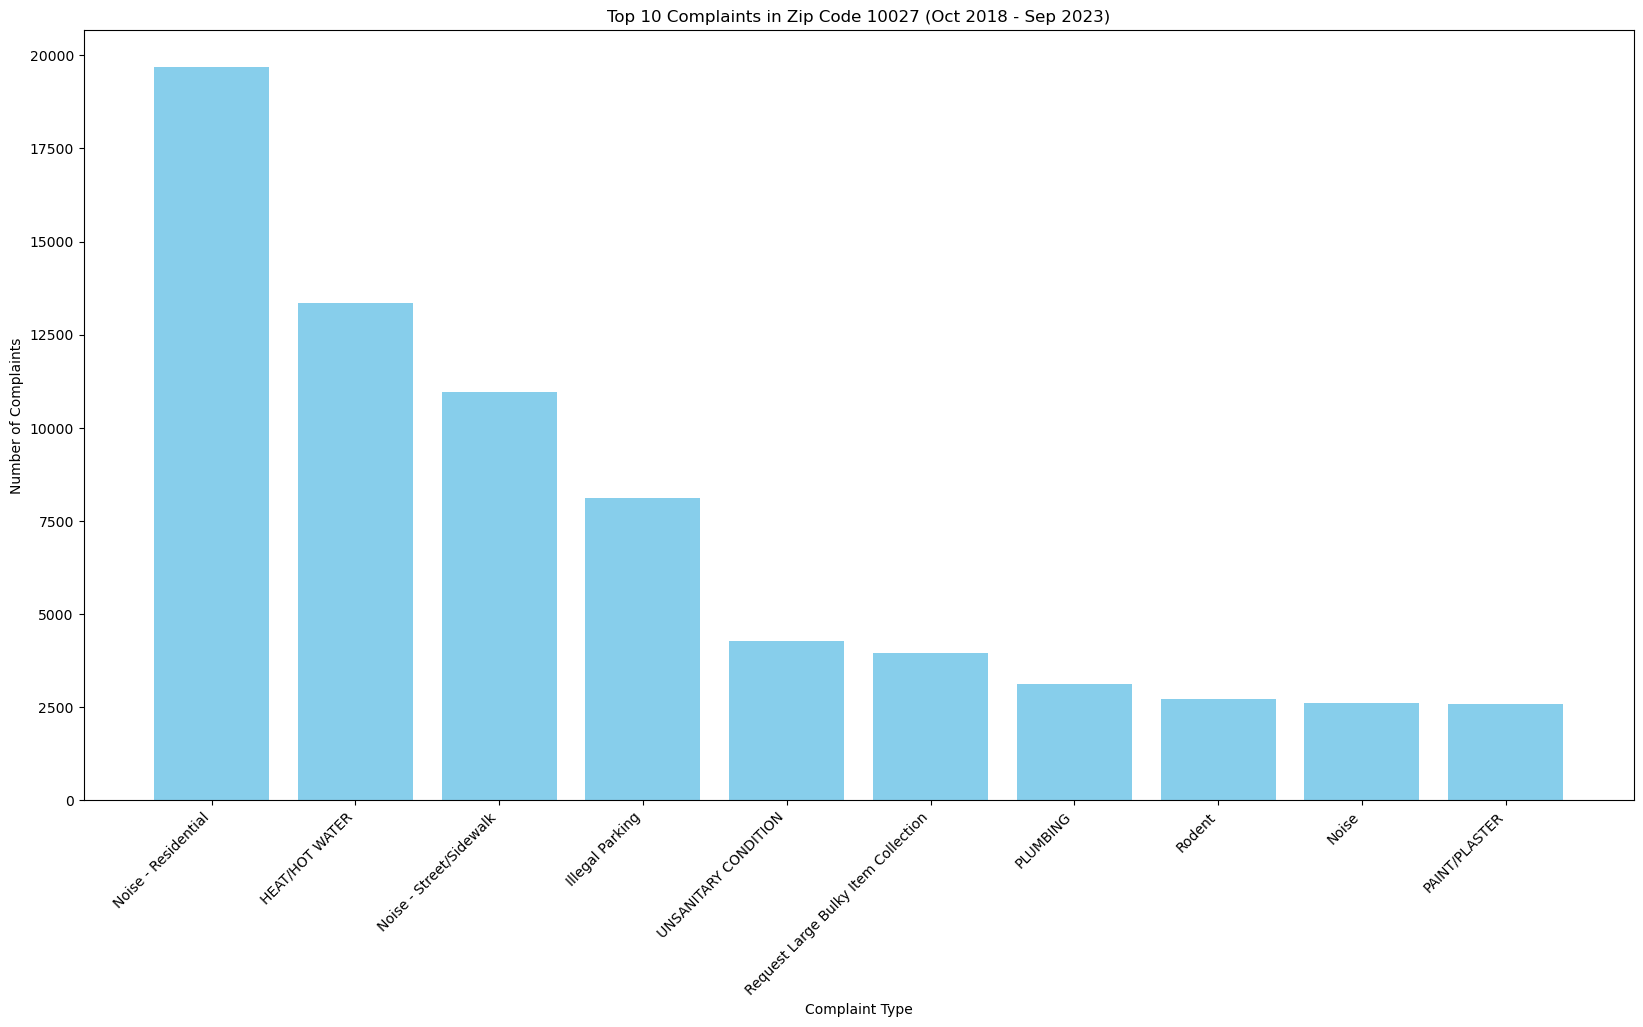

In [32]:
# Show the result
complaints_data_10027 = get_data_for_most_common_complaints()
plot_most_common_complaints(complaints_data_10027)

### Visualization 3: Is there any correlation between rent, trees, and complaints at all?

**Question:** Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the other subplot shows rent compared to the number of complaints by zip code.

**Solution:**
- **Objective:** Examine the relationship between average rent, tree count, and complaint count in NYC zip codes from 2015 to 2023.
- **Data Processing:** Retrieves and merges data on average rent, tree count, and complaint count per zip code.
- **Visualization:** Creates two scatter plots in one figure, one showing rent vs. tree count and the other showing rent vs. complaint count, with a shared x-axis for average rent.


In [33]:
def get_data_for_correlation()->pd.DataFrame:
    # Query to get average rent by zip code
    rent_query = """
    SELECT 
         zipcode, 
         AVG(rent) as average_rent
    FROM 
         nyc_zillow
    WHERE 
         recorded_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    # Query to get tree count by zip code
    tree_query = """
    SELECT 
         zipcode, 
         COUNT(*) as tree_count
    FROM 
         nyc_tree
    WHERE
         status = 'Alive'
    GROUP BY 
         zipcode
    """

    # Query to get complaint count by zip code
    complaint_query = """
    SELECT 
         zipcode, 
         COUNT(*) as complaint_count
    FROM 
         nyc_311
    WHERE 
         created_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    # Execute queries and return dataframes
    with engine.connect() as conn:
        rent_data = pd.read_sql(rent_query, conn)
        tree_data = pd.read_sql(tree_query, conn)
        complaint_data = pd.read_sql(complaint_query, conn)

    return rent_data, tree_data, complaint_data

In [34]:
def plot_correlation(rent_df:pd.DataFrame, tree_df:pd.DataFrame, complaint_df:pd.DataFrame):
    # Merging dataframes on zipcode
    merged_df = rent_df.merge(tree_df, on='zipcode').merge(complaint_df, on='zipcode')

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Subplot 1: Rent vs Tree Count
    ax1.scatter(merged_df['average_rent'], merged_df['tree_count'], color='green')
    ax1.set_title('Average Rent vs Tree Count by Zip Code')
    ax1.set_ylabel('Tree Count')

    # Subplot 2: Rent vs Complaint Count
    ax2.scatter(merged_df['average_rent'], merged_df['complaint_count'], color='red')
    ax2.set_title('Average Rent vs Complaint Count by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Complaint Count')

    plt.show()

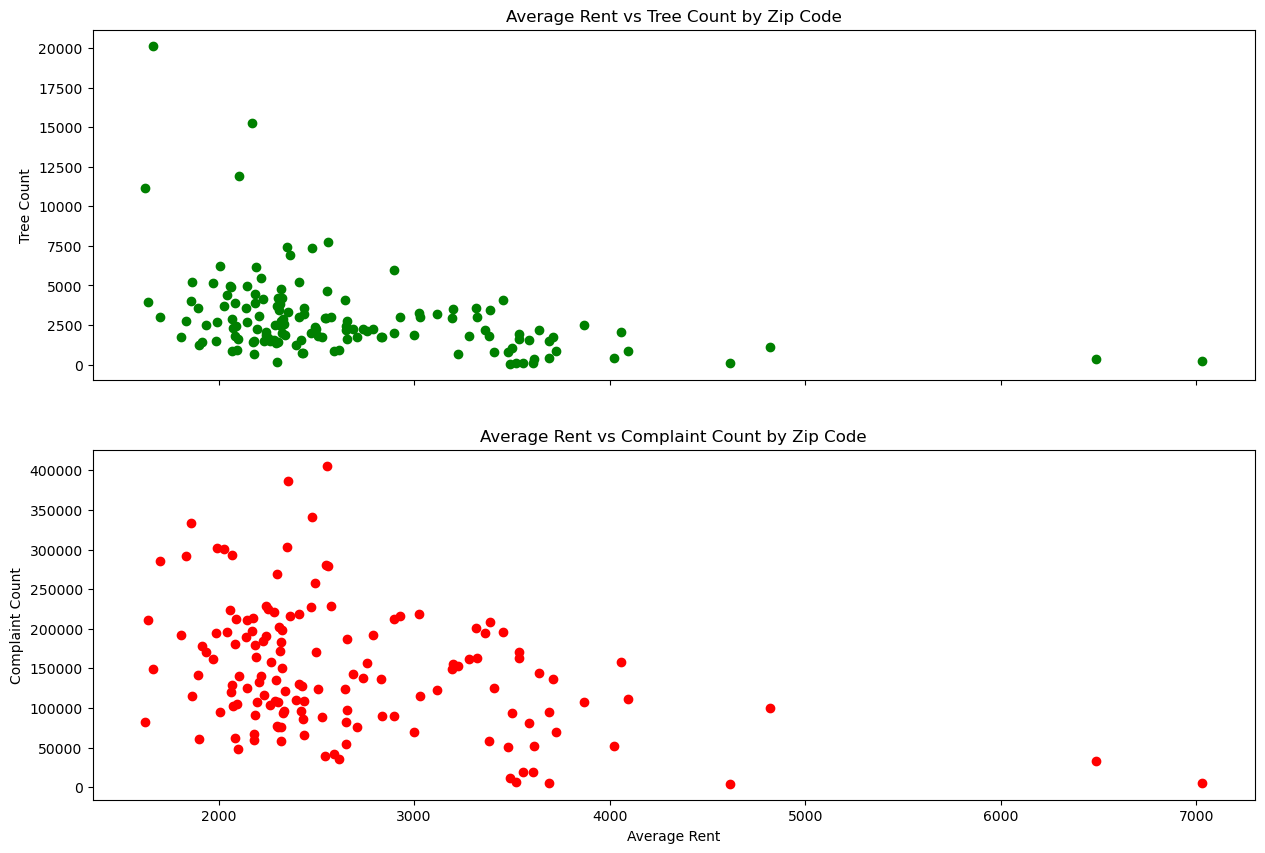

In [35]:
# Show the result
rent_data, tree_data, complaint_data = get_data_for_correlation()
plot_correlation(rent_data, tree_data, complaint_data)

### Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?

**Question:** Create a boxplot, where the x-axis is average rent in September 2023, separated into $1000 bins (i.e. $0-1000, $1001-2000, etc), and the y-axis is the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).

**Solution:**
- **Objective:** Analyze if higher rent is associated with fewer 311 complaints in NYC from October 2022 to September 2023.
- **Data Processing:** Gathers average rent for September 2023 and complaint counts over a year, then merges these by zip code.
- **Visualization:** Creates a boxplot with rent divided into $1000 bins on the x-axis and complaint counts on the y-axis.

In [36]:
def get_data_for_afford_vs_complaints()->pd.DataFrame:
    # Query to get average rent by zip code for September 2023
    rent_query = """
    SELECT 
         zipcode, 
         AVG(rent) as average_rent
    FROM 
         nyc_zillow
    WHERE 
         recorded_date BETWEEN '2023-09-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    # Query to get complaint count by zip code
    complaint_query = """
    SELECT 
         zipcode, 
         COUNT(*) as complaint_count
    FROM 
         nyc_311
    WHERE 
         created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    with engine.connect() as conn:
        rent_data = pd.read_sql(rent_query, conn)
        complaint_data = pd.read_sql(complaint_query, conn)

    # Merging dataframes on zipcode
    merged_data = rent_data.merge(complaint_data, on='zipcode')

    # Categorizing rent into bins
    rent_bins = pd.cut(merged_data['average_rent'], bins=range(0, int(merged_data['average_rent'].max()) + 1000, 1000), right=False)
    merged_data['rent_bins'] = rent_bins

    return merged_data

In [37]:
def plot_afford_vs_complaints(dataframe:pd.DataFrame):
    fig, ax = plt.subplots(figsize=(20, 10))

    # Creating a boxplot
    dataframe.boxplot(column='complaint_count', by='rent_bins', ax=ax, grid=False)

    # Labeling and styling
    ax.set_title('Number of 311 Complaints vs Average Rent')
    ax.set_xlabel('Average Rent Bins ($)')
    ax.set_ylabel('Number of 311 Complaints')
    plt.suptitle('')  # Remove default Pandas title
    plt.xticks(rotation=45)

    plt.show()

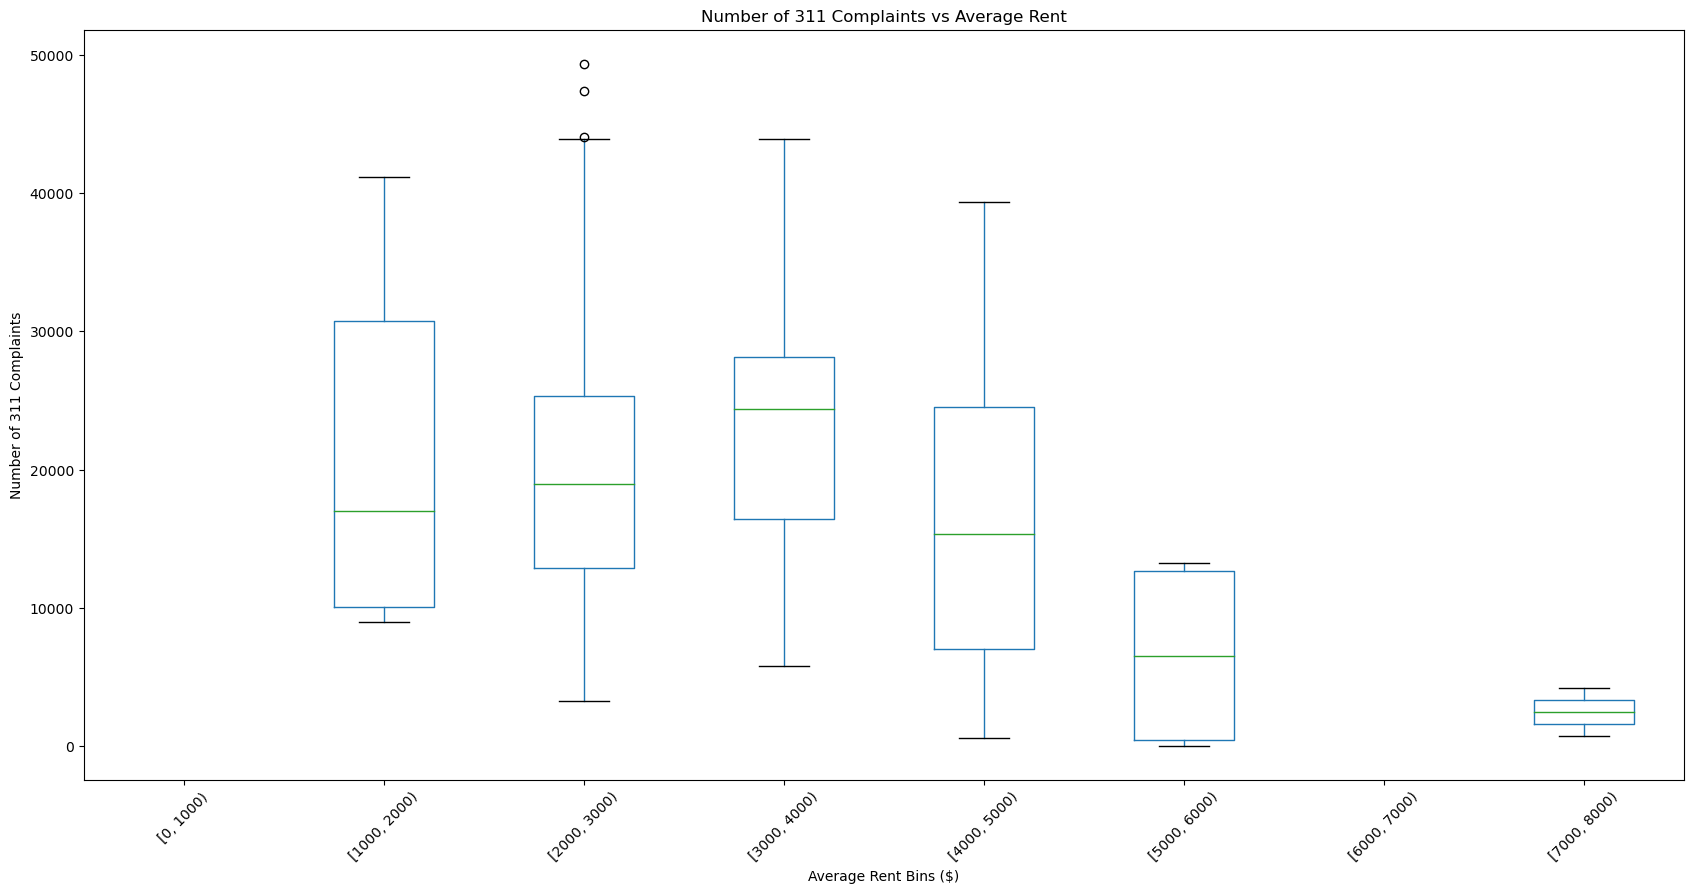

In [38]:
# Show the result
afford_vs_complaint = get_data_for_afford_vs_complaints()
plot_afford_vs_complaints(afford_vs_complaint)

### Visualization 5: Where were the recent 311 incidents reported from in the immediate area?
**Question:** Create a geospatial plot of the coordinates of reported 311 incidents that happened between January 1st, 2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of the same coordinate from Query 6 in Part 3.

**Solution:**
- **Objective:** Map the locations of 311 incidents reported within a 1-kilometer radius of a specific coordinate point (from Query 6) in NYC between January 1st, 2023, and September 30th, 2023.
- **Data Processing:** Retrieves longitude and latitude data for incidents that occurred within the specified timeframe and proximity to the given coordinates.
- **Visualization:** Uses geospatial plotting to display each incident as a point on a map, centered around the target coordinate.

In [10]:
def get_data_for_incidents_data()->pd.DataFrame:
    # Modify the query to extract longitude and latitude
    incident_query = f"""
    SELECT 
         ST_X(location::geometry) as longitude, 
         ST_Y(location::geometry) as latitude
    FROM 
         nyc_311
    WHERE 
        created_date BETWEEN '2023-01-01' AND '2023-09-30'
        AND ST_DWithin(location::geography, ST_GeomFromWKB('\\x{point_wkb}', 4326)::geography, 1000)
    """

    with engine.connect() as conn:
        incidents_data = pd.read_sql(incident_query, conn)

    return incidents_data


In [11]:
def plot_incidents_data(dataframe: pd.DataFrame, point_size=5):
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe['longitude'], dataframe['latitude']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, markersize=point_size, color='red', marker='o')
    
    # Replace 'longitude' and 'latitude' with the actual coordinates of the campus
    campus_longitude = -73.9625
    campus_latitude = 40.8074
    
    # Plot and label the special point (campus)
    plt.scatter(campus_longitude, campus_latitude, color='blue', s=50)  # s is the size of the point
    plt.text(campus_longitude, campus_latitude, ' Campus', verticalalignment='bottom', horizontalalignment='right')

    plt.title("311 Incidents Near Latitude 40.8074, Longitude -73.9625")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")    
    
    # Center the plot around the campus coordinates
    ax.set_xlim(campus_longitude - 0.015, campus_longitude + 0.015)
    ax.set_ylim(campus_latitude - 0.015, campus_latitude + 0.015)
    
    plt.show()

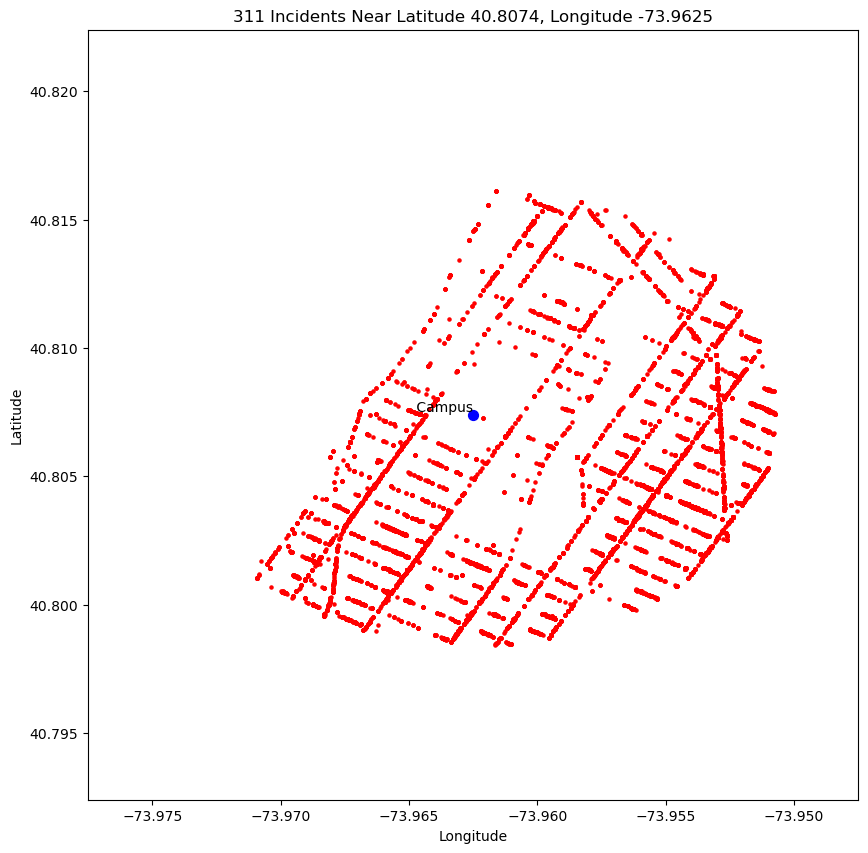

In [12]:
# Show the result
incidents_data = get_data_for_incidents_data()
plot_incidents_data(incidents_data)

### Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?

**Question:** Create a geospatial plot of two sets of data: the coordinates of trees in NYC, and the coordinates of "New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 (inclusive).

**Solution:**

- **Objective:** Compare the locations of existing trees and "New Tree Request" complaints in NYC from October 2018 to September 2023.
- **Data Retrieval:** Gathers coordinates for all existing trees and for "New Tree Request" complaints within the specified timeframe.
- **Visualization:** Produces a geospatial plot displaying trees as green points and new tree requests as red points.

In [45]:
def get_data_for_improve_tree()->pd.DataFrame:

    # Query for existing tree coordinates
    tree_query = """
    SELECT 
        tree_id, 
        ST_X(location::geometry) AS longitude, 
        ST_Y(location::geometry) AS latitude
    FROM 
        nyc_tree
    """

    # Query for "New Tree Request" complaint coordinates
    complaint_query = """
    SELECT 
        unique_key, 
        ST_X(location::geometry) AS longitude, 
        ST_Y(location::geometry) AS latitude
    FROM 
        nyc_311
    WHERE 
        complaint_type = 'New Tree Request' AND
        created_date BETWEEN '2018-10-01' AND '2023-09-30'
    """

    # Execute queries and return dataframes
    tree_df = pd.read_sql(tree_query, engine)
    complaint_df = pd.read_sql(complaint_query, engine)

    return tree_df, complaint_df

In [46]:
def plot_improve_tree(tree_df:pd.DataFrame, complaint_df:pd.DataFrame):
    # Create GeoDataFrames
    tree_gdf = gpd.GeoDataFrame(tree_df, geometry=gpd.points_from_xy(tree_df.longitude, tree_df.latitude))
    complaint_gdf = gpd.GeoDataFrame(complaint_df, geometry=gpd.points_from_xy(complaint_df.longitude, complaint_df.latitude))

    # Plot
    fig, ax = plt.subplots(figsize=(15, 15))
    tree_gdf.plot(ax=ax, marker='o', color='green', markersize=5, label='Existing Trees')
    complaint_gdf.plot(ax=ax, marker='x', color='red', markersize=5, label='New Tree Requests')
    plt.title("NYC Tree Locations vs New Tree Requests (Oct 2018 - Sep 2023)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()

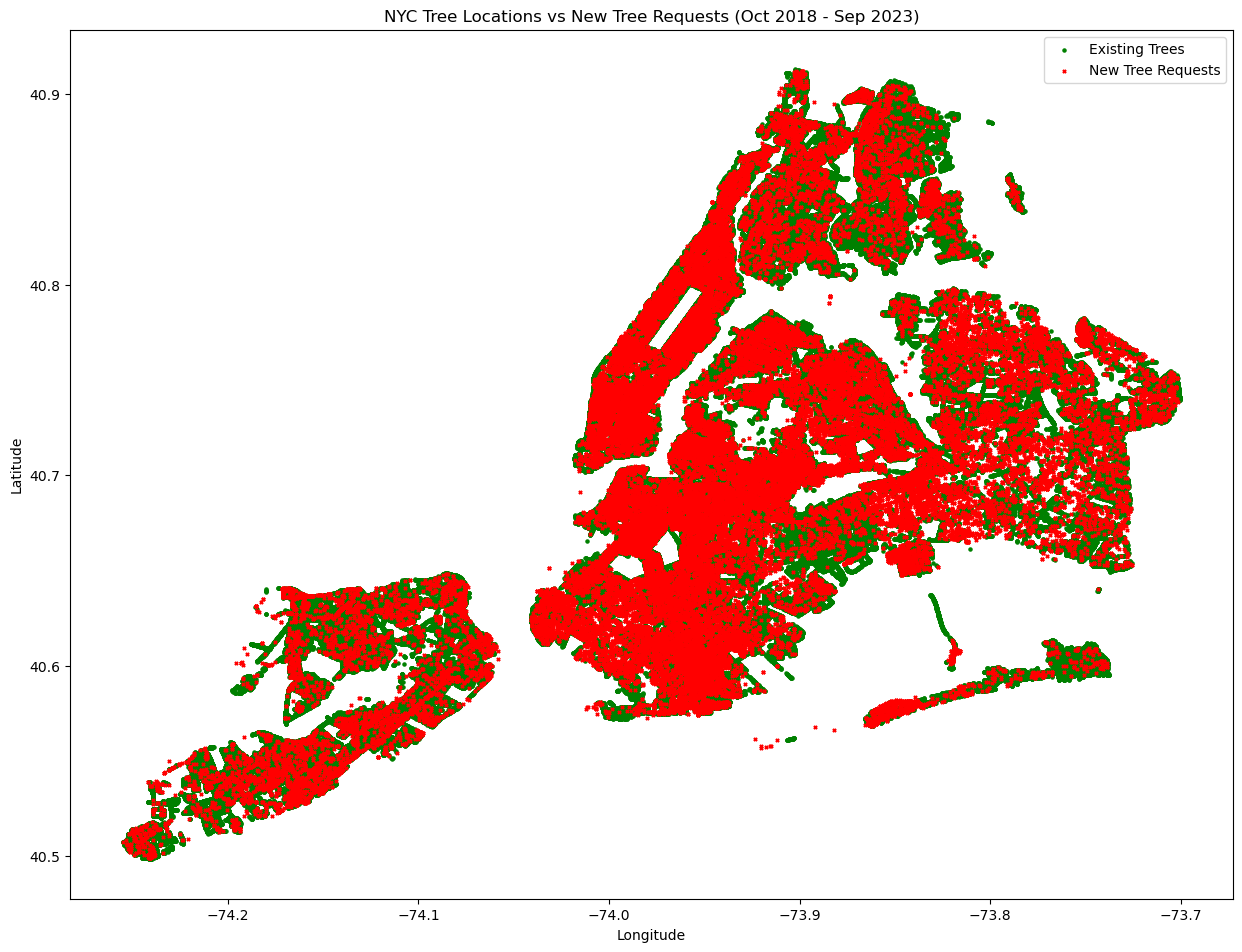

In [47]:
# Show the result
tree_df, complaint_df = get_data_for_improve_tree()
plot_improve_tree(tree_df, complaint_df)